In [128]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [129]:
df_lstm= yf.download("AMZN" , start = "2021-01-01" , interval = '1d')

[*********************100%***********************]  1 of 1 completed


In [130]:
df_lstm.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [131]:
df_lstm.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [132]:
df_lstm.dropna(inplace=True)

In [133]:
df_lstm.describe()

,Open,High,Low,Close,Adj Close,Volume
count,661.000000,661.000000,661.000000,661.000000,661.000000,6.610000e+02
mean,138.321986,140.126477,136.413437,138.239074,138.239074,6.990305e+07
std,29.193426,29.186731,29.153537,29.130119,29.130119,2.804089e+07
min,82.800003,83.480003,81.430000,81.820000,81.820000,2.826480e+07
25%,112.160004,114.080002,109.320000,112.209999,112.209999,5.211240e+07
50%,142.050003,144.243500,139.500000,142.100006,142.100006,6.298400e+07
75%,165.001007,166.392502,163.606506,164.949493,164.949493,7.830800e+07
max,187.199997,188.654007,184.839493,186.570496,186.570496,2.726620e+08


In [134]:
df_lstm = df_lstm.asfreq("d")

In [135]:
df_lstm.isnull().sum()

Open         296
High         296
Low          296
Close        296
Adj Close    296
Volume       296
dtype: int64

In [136]:
df_lstm = df_lstm.fillna(method  = "bfill")

In [137]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import MDS
from tqdm.notebook import tnrange

In [138]:
# Filtering the required data 
data = df_lstm[['Close' , 'Volume']]
data.head()

,Close,Volume
Date,,
2021-01-04,159.331497,88228000.0
2021-01-05,160.925507,53110000.0
2021-01-06,156.919006,87896000.0
2021-01-07,158.108002,70290000.0
2021-01-08,159.134995,70754000.0


In [139]:
def splitSequence(sequence, n_steps):
    
    X, y = list(), list()
    for i in range(len(sequence)):
        
        # find the last index of sequence
        last_index = i + n_steps
        
        # check if last_index greater than len(sequence)-1, then break
        if last_index > len(sequence)-1:
            break
            
        # input and output of the sequence
        seq_x, seq_y = sequence[i:last_index], sequence[last_index]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [140]:
X, Y = splitSequence(data['Close'], n_steps=32)

In [141]:
X[:10]

array([[159.33149719, 160.92550659, 156.91900635, 158.10800171,
        159.13499451, 155.710495  , 155.710495  , 155.710495  ,
        156.04150391, 158.29449463, 156.37350464, 155.2124939 ,
        156.03799438, 156.03799438, 156.03799438, 156.03799438,
        163.16900635, 165.34950256, 164.61149597, 164.69999695,
        164.69999695, 164.69999695, 166.3065033 , 161.6289978 ,
        161.8809967 , 160.30999756, 167.14399719, 167.14399719,
        167.14399719, 169.        , 165.62649536, 166.55000305],
       [160.92550659, 156.91900635, 158.10800171, 159.13499451,
        155.710495  , 155.710495  , 155.710495  , 156.04150391,
        158.29449463, 156.37350464, 155.2124939 , 156.03799438,
        156.03799438, 156.03799438, 156.03799438, 163.16900635,
        165.34950256, 164.61149597, 164.69999695, 164.69999695,
        164.69999695, 166.3065033 , 161.6289978 , 161.8809967 ,
        160.30999756, 167.14399719, 167.14399719, 167.14399719,
        169.        , 165.62649536, 166

In [142]:
Y[:10]

array([167.60749817, 166.14700317, 166.14700317, 166.14700317,
       165.25      , 164.32899475, 163.10650635, 163.88549805,
       163.44749451, 163.44749451])

In [143]:
# Testing Set length 
test_length = data[(data.index >= '2023-01-01')].shape[0]
print(test_length)
# Train length
train_length = data[(data.index < '2023-01-01')].shape[0]
print(train_length)



230
727


In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Dropout , LSTM , Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint , ReduceLROnPlateau

In [145]:
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X[:5][:5]

array([[[159.33149719],
        [160.92550659],
        [156.91900635],
        [158.10800171],
        [159.13499451],
        [155.710495  ],
        [155.710495  ],
        [155.710495  ],
        [156.04150391],
        [158.29449463],
        [156.37350464],
        [155.2124939 ],
        [156.03799438],
        [156.03799438],
        [156.03799438],
        [156.03799438],
        [163.16900635],
        [165.34950256],
        [164.61149597],
        [164.69999695],
        [164.69999695],
        [164.69999695],
        [166.3065033 ],
        [161.6289978 ],
        [161.8809967 ],
        [160.30999756],
        [167.14399719],
        [167.14399719],
        [167.14399719],
        [169.        ],
        [165.62649536],
        [166.55000305]],

       [[160.92550659],
        [156.91900635],
        [158.10800171],
        [159.13499451],
        [155.710495  ],
        [155.710495  ],
        [155.710495  ],
        [156.04150391],
        [158.29449463],
        [156.3

In [146]:
Xtrain = X[:train_length]
Xtest = X[train_length:]
Ytrain = Y[:train_length]
Ytest = Y[train_length:]

In [147]:
save_best = ModelCheckpoint("best_weights.h5", monitor='val_loss', save_best_only=True, save_weights_only=True)

In [148]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=4, min_lr=0.00001,verbose = 1)

In [149]:
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(32,1)))
model.add(Dense(1))
model

In [150]:
opt = tf.keras.optimizers.Adam(learning_rate=0.002)

In [152]:
model.compile(optimizer=opt, loss='mse')

In [153]:
history = model.fit(Xtrain , Ytrain, epochs=10, batch_size = 1, verbose=1, shuffle=False, validation_data=(Xtest, Ytest), callbacks=[reduce_lr , save_best])
#history = model.fit(X, Y, epochs=1, verbose=1)

Epoch 1/10
727/727 [==============================] - 23s 24ms/step - loss: 3431.2195 - val_loss: 137.5775 - lr: 0.0020
Epoch 2/10
727/727 [==============================] - 16s 22ms/step - loss: 125.5943 - val_loss: 127.3470 - lr: 0.0020
Epoch 3/10
727/727 [==============================] - 16s 22ms/step - loss: 11569.5488 - val_loss: 258.6028 - lr: 0.0020
Epoch 4/10
727/727 [==============================] - 16s 22ms/step - loss: 92.0929 - val_loss: 265.7253 - lr: 0.0020
Epoch 5/10
727/727 [==============================] - 13s 18ms/step - loss: 86.0028 - val_loss: 158.0390 - lr: 0.0020
Epoch 6/10
726/727 [============================>.] - ETA: 0s - loss: 91.8765
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
727/727 [==============================] - 15s 20ms/step - loss: 91.7524 - val_loss: 140.1852 - lr: 0.0020
Epoch 7/10
727/727 [==============================] - 16s 22ms/step - loss: 147.5968 - val_loss: 51.0562 - lr: 5.0000e-04
Epoch 8/10
727/727 [=

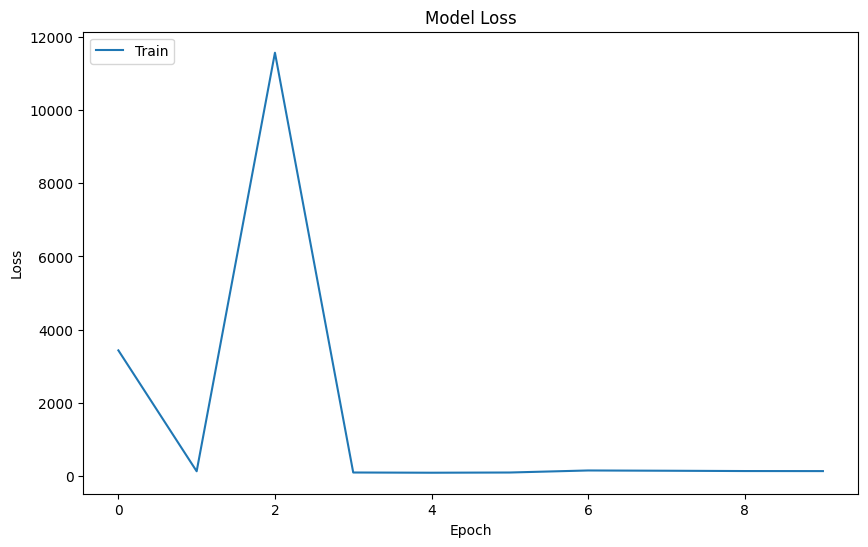

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize =(10, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [155]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [157]:
# Load the best weights
model.load_weights("best_weights.h5")

In [158]:
Predictions = model.predict(Xtest)

7/7 [==============================] - 0s 8ms/step


In [159]:
Predictions

array([[ 95.3516  ],
       [ 95.788704],
       [ 96.7317  ],
       [ 96.59834 ],
       [ 96.45539 ],
       [ 98.23838 ],
       [100.193474],
       [101.18115 ],
       [100.13363 ],
       [100.99749 ],
       [102.46888 ],
       [104.189156],
       [103.321434],
       [105.75519 ],
       [104.08801 ],
       [104.40749 ],
       [103.38857 ],
       [103.790016],
       [102.430244],
       [103.70371 ],
       [103.56833 ],
       [104.03689 ],
       [103.26975 ],
       [103.26678 ],
       [102.688934],
       [104.16306 ],
       [104.59582 ],
       [104.51145 ],
       [103.95809 ],
       [102.57915 ],
       [101.13694 ],
       [102.040375],
       [100.93049 ],
       [100.79823 ],
       [100.44913 ],
       [100.03637 ],
       [ 99.694275],
       [ 99.22452 ],
       [ 99.093285],
       [ 99.65147 ],
       [ 99.657974],
       [ 99.0241  ],
       [ 98.41898 ],
       [ 97.790825],
       [ 97.80575 ],
       [ 97.47784 ],
       [ 97.02062 ],
       [ 97.0

In [162]:
Actual = (Ytest)

In [163]:
Actual

array([112.91000366, 103.38999939, 102.18000031, 102.18000031,
       102.18000031, 102.11000061, 100.05000305,  98.23999786,
        97.61000061,  99.54000092,  99.54000092,  99.54000092,
        99.69999695, 101.16000366,  98.15000153,  97.19999695,
        94.58000183,  94.58000183,  94.58000183,  94.58000183,
        95.79000092,  95.81999969,  93.5       ,  93.76000214,
        93.76000214,  93.76000214,  94.23000336,  92.16999817,
        92.12999725,  94.90000153,  93.75      ,  93.75      ,
        93.75      ,  93.55000305,  93.91999817,  92.25      ,
        90.73000336,  92.43000031,  92.43000031,  92.43000031,
        94.87999725,  96.19999695, 100.04000092,  98.94999695,
        97.70999908,  97.70999908,  97.70999908, 100.61000061,
        98.69999695,  98.70999908,  98.12999725,  98.04000092,
        98.04000092,  98.04000092,  97.23999786, 100.25      ,
       102.        , 103.29000092, 102.41000366, 102.41000366,
       102.41000366, 103.94999695, 101.09999847, 102.05

In [164]:
Predictions = np.squeeze(Predictions , axis = 1)

In [166]:
# Creating Sample Test Dataframe
test_dataframe_dict = {'Actual' : list(Actual) , 'Predicted' : list(Predictions)}
test_df = pd.DataFrame.from_dict(test_dataframe_dict)
test_df.head()


,Actual,Predicted
0,112.910004,95.351601
1,103.389999,95.788704
2,102.180000,96.731697
3,102.180000,96.598343
4,102.180000,96.455391


In [167]:
# Check the trend in Volume Traded
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x = test_df.index , y = Actual , mode = 'lines' , name='Actual'))
fig.add_trace(go.Scatter(x = test_df.index , y = Predictions , mode = 'lines' , name='Predicted'))
fig.show()


In [168]:
from sklearn.metrics import mean_absolute_error
# Evaluating the model using MAE Evaluation Metric
print(mean_absolute_error(Actual, Predictions))
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Actual, Predictions))
##R² score also known as the coefficient of determination gives the measure of how good a model fits to a given dataset. 
##It indicates how closer are the predicted values to the actual values.

4.283323808149858
28.50661951093993


In [169]:
from sklearn.metrics import r2_score
print(r2_score(Actual, Predictions))

0.8765015187350649
